# import library

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import isnan, when, count, col
spark = SparkSession.builder.appName('classification').getOrCreate()
from pyspark.ml.feature import QuantileDiscretizer

21/12/10 22:36:45 WARN Utils: Your hostname, SheepB resolves to a loopback address: 127.0.1.1; using 192.168.1.107 instead (on interface wlo1)
21/12/10 22:36:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/10 22:36:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/12/10 22:36:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Read data and preprocessing

In [2]:
!ls Data

Absenteeism_at_work.csv  income_evaluation.csv	titanic.csv
fetal_health.csv	 mushrooms.csv


test on 4 files csv: mushrooms.csv, fetal_health.csv, income_evaluation.csv

In [3]:
files = ['mushrooms.csv', 'fetal_health.csv', 'income_evaluation.csv', 'titanic.csv']

## mushrooms.csv

In [4]:
df_mushroom = spark.read.csv('Data/mushrooms.csv', inferSchema=True, header=True, sep=',')
df_mushroom.limit(10).toPandas()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [5]:
(df_mushroom.count(), len(df_mushroom.columns))

(8124, 23)

In [6]:
df_mushroom.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

In [7]:
n_old_record = df_mushroom.count()
print('number of record before remove duplicates:', n_old_record)
df_mushroom = df_mushroom.dropDuplicates()
print('number of record after remove duplicates:', df_mushroom.count())
print('number of duplicates:', n_old_record - df_mushroom.count())

number of record before remove duplicates: 8124
number of record after remove duplicates: 8124
number of duplicates: 0


- Count nan value

In [8]:
df_mushroom.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_mushroom.columns]).toPandas()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## fetal_health.csv

In [9]:
df_fetal = spark.read.csv('Data/fetal_health.csv', inferSchema=True, header=True, sep=',')
df_fetal.limit(10).toPandas()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.000,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.000,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.000,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
5,134.0,0.001,0.0,0.010,0.009,0.0,0.002,26.0,5.9,0.0,...,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,3.0
6,134.0,0.001,0.0,0.013,0.008,0.0,0.003,29.0,6.3,0.0,...,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,3.0
7,122.0,0.000,0.0,0.000,0.000,0.0,0.000,83.0,0.5,6.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
8,122.0,0.000,0.0,0.002,0.000,0.0,0.000,84.0,0.5,5.0,...,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
9,122.0,0.000,0.0,0.003,0.000,0.0,0.000,86.0,0.3,6.0,...,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,3.0


In [10]:
(df_fetal.count(), len(df_fetal.columns))

(2126, 22)

In [11]:
df_fetal.printSchema()

root
 |-- baseline value: double (nullable = true)
 |-- accelerations: double (nullable = true)
 |-- fetal_movement: double (nullable = true)
 |-- uterine_contractions: double (nullable = true)
 |-- light_decelerations: double (nullable = true)
 |-- severe_decelerations: double (nullable = true)
 |-- prolongued_decelerations: double (nullable = true)
 |-- abnormal_short_term_variability: double (nullable = true)
 |-- mean_value_of_short_term_variability: double (nullable = true)
 |-- percentage_of_time_with_abnormal_long_term_variability: double (nullable = true)
 |-- mean_value_of_long_term_variability: double (nullable = true)
 |-- histogram_width: double (nullable = true)
 |-- histogram_min: double (nullable = true)
 |-- histogram_max: double (nullable = true)
 |-- histogram_number_of_peaks: double (nullable = true)
 |-- histogram_number_of_zeroes: double (nullable = true)
 |-- histogram_mode: double (nullable = true)
 |-- histogram_mean: double (nullable = true)
 |-- histogram_medi

In [12]:
n_old_record = df_fetal.count()
print('number of record before remove duplicates:', n_old_record)
df_fetal = df_fetal.dropDuplicates()
print('number of record after remove duplicates:', df_fetal.count())
print('number of duplicates:', n_old_record - df_fetal.count())

number of record before remove duplicates: 2126
number of record after remove duplicates: 2113
number of duplicates: 13


In [13]:
df_fetal.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_fetal.columns]).toPandas()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df = pd.read_csv('Data/fetal_health.csv')
df_count = df.nunique()
columns_discretizer = list(df_count[df_count >= 32].index)


for column in columns_discretizer:
    discretizer = QuantileDiscretizer(numBuckets=30, inputCol=column, outputCol=column.strip() + '_dct')
    df_fetal = discretizer.fit(df_fetal).transform(df_fetal)
    df_fetal = df_fetal.drop(column)

21/12/10 22:37:03 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 26 buckets as a result.
21/12/10 22:37:03 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 11 buckets as a result.
21/12/10 22:37:04 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 23 buckets as a result.
21/12/10 22:37:05 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 14 buckets as a result.
21/12/10 22:37:07 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 29 buckets as a result.
21/12/10 22:37:07 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 23 buckets as a result.


## income_evaluation.csv

In [15]:
df_income = spark.read.csv('Data/income_evaluation.csv', inferSchema=True, header=True, sep=',')
df_income.limit(10).toPandas()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [16]:
(df_income.count(), len(df_income.columns))

(32561, 15)

In [17]:
df_income.printSchema()

root
 |-- age: integer (nullable = true)
 |--  workclass: string (nullable = true)
 |--  fnlwgt: integer (nullable = true)
 |--  education: string (nullable = true)
 |--  education-num: integer (nullable = true)
 |--  marital-status: string (nullable = true)
 |--  occupation: string (nullable = true)
 |--  relationship: string (nullable = true)
 |--  race: string (nullable = true)
 |--  sex: string (nullable = true)
 |--  capital-gain: integer (nullable = true)
 |--  capital-loss: integer (nullable = true)
 |--  hours-per-week: integer (nullable = true)
 |--  native-country: string (nullable = true)
 |--  income: string (nullable = true)



In [18]:
n_old_record = df_income.count()
print('number of record before remove duplicates:', n_old_record)
df_income = df_income.dropDuplicates()
print('number of record after remove duplicates:', df_income.count())
print('number of duplicates:', n_old_record - df_income.count())

number of record before remove duplicates: 32561
number of record after remove duplicates: 32537
number of duplicates: 24


In [19]:
df_income.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_income.columns]).toPandas()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
df_income.toPandas()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,26,Private,59306,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,41,Local-gov,42346,Some-college,10,Divorced,Other-service,Not-in-family,Black,Female,0,0,24,United-States,<=50K
2,24,Private,247564,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,31,Private,223212,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Mexico,<=50K
4,20,Private,275691,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,28,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32532,33,Self-emp-not-inc,195891,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,<=50K
32533,26,Private,31143,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
32534,38,Private,33397,HS-grad,9,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States,<=50K
32535,48,Private,109814,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1977,45,United-States,>50K


In [21]:
columns_discretizer = ['age', ' fnlwgt', ' capital-gain', ' hours-per-week', ' capital-loss']

for column in columns_discretizer:
    discretizer = QuantileDiscretizer(numBuckets=30, inputCol=column, outputCol=column.strip() + '_dct')
    df_income = discretizer.fit(df_income).transform(df_income)
    df_income = df_income.drop(column)
df_income = df_income.drop(' native-country')

21/12/10 22:37:14 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 4 buckets as a result.
21/12/10 22:37:15 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 14 buckets as a result.
21/12/10 22:37:15 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 3 buckets as a result.


# Classification

In [22]:
df_income.toPandas()

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,income,age_dct,fnlwgt_dct,capital-gain_dct,hours-per-week_dct,capital-loss_dct
0,Private,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,<=50K,6.0,2.0,1.0,8.0,1.0
1,Local-gov,Some-college,10,Divorced,Other-service,Not-in-family,Black,Female,<=50K,18.0,1.0,1.0,3.0,1.0
2,Private,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,<=50K,5.0,23.0,1.0,8.0,1.0
3,Private,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,<=50K,10.0,21.0,1.0,8.0,1.0
4,Private,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,<=50K,2.0,24.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32532,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,<=50K,12.0,17.0,1.0,9.0,1.0
32533,Private,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,<=50K,6.0,0.0,1.0,8.0,1.0
32534,Private,HS-grad,9,Divorced,Sales,Unmarried,White,Female,<=50K,16.0,0.0,1.0,8.0,1.0
32535,Private,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,>50K,22.0,6.0,1.0,9.0,2.0


In [23]:
 df_income.columns

[' workclass',
 ' education',
 ' education-num',
 ' marital-status',
 ' occupation',
 ' relationship',
 ' race',
 ' sex',
 ' income',
 'age_dct',
 'fnlwgt_dct',
 'capital-gain_dct',
 'hours-per-week_dct',
 'capital-loss_dct']

In [24]:
def run_model(df, label_col):
    features_col = df.columns
    features_col.remove(label_col)
    featuresIndexer = [StringIndexer(inputCol=column, outputCol=column+"Indexer").fit(df) 
                       for column in features_col]
    
    for featureIndexer in featuresIndexer:
        df = featureIndexer.transform(df)
        
    features_col = [feature_col + "Indexer" for feature_col in features_col]
    vec_assembler = VectorAssembler(inputCols = features_col , outputCol = "features")
    features_df = vec_assembler.transform(df).select('features', label_col)
    
    train_df, test_df = features_df.randomSplit([0.8, 0.2])
    
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(train_df)
    labelIndexer = StringIndexer(inputCol=label_col, outputCol="indexedLabel").fit(train_df)
    scalerModel = StandardScaler(inputCol="indexedFeatures", outputCol="scaledFeatures",
                            withStd=True, withMean=False)
    
    def run_model(model_parameter):
        pipeline = Pipeline(stages=[labelIndexer, featureIndexer, scalerModel, model_parameter])
        model = pipeline.fit(train_df)
        test_pred = model.transform(test_df)
        # accuracy
    
        accuracy = MulticlassClassificationEvaluator( labelCol="indexedLabel", 
                                                    predictionCol="prediction", 
                                                    metricName="accuracy").evaluate(test_pred)
    
        # precision
        precision = MulticlassClassificationEvaluator( labelCol="indexedLabel", 
                                                    predictionCol="prediction", 
                       
                                                     metricName="weightedPrecision").evaluate(test_pred)
        
        # recall
        recall = MulticlassClassificationEvaluator( labelCol="indexedLabel", 
                                                    predictionCol="prediction", 
                                                    metricName="weightedRecall").evaluate(test_pred)
        
        y_true = test_pred.select("indexedLabel")
        y_true = y_true.toPandas()
    
        y_pred = test_pred.select("prediction")
        y_pred = y_pred.toPandas()
    
        cnf_matrix = confusion_matrix(y_true, y_pred)
        
        return accuracy, precision, recall, cnf_matrix
    
    def print_result(accuracy, precision, recall, cnf_matrix):
        print("result on test data")
        print(f'accuracy: {accuracy}')
        print(f'precision: {precision}')
        print(f'recall: {recall}')
        f_cm = pd.DataFrame(cnf_matrix, index = [str(i) for i in range(len(cnf_matrix))],
                      columns = [str(i) for i in range(len(cnf_matrix))])
        plt.figure(figsize = (10,7))
        sns.heatmap(f_cm, annot=True)
        
        
    decision_tree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='features', maxDepth=20, maxBins=32)
    
    accuracy, precision, recall, cnf_matrix = run_model(decision_tree)
    print("\n--Result of decision Tree---")
    print_result(accuracy, precision, recall, cnf_matrix)
    
    
    naive_bayes = NaiveBayes(labelCol='indexedLabel', featuresCol='features', smoothing=1.0, modelType="multinomial")
    accuracy, precision, recall, cnf_matrix = run_model(naive_bayes)
    print("\n--Result of naive bayes---")
    print_result(accuracy, precision, recall, cnf_matrix)
    
    random_forest = RandomForestClassifier(labelCol='indexedLabel', maxDepth=20, numTrees=10)
    accuracy, precision, recall, cnf_matrix = run_model(random_forest)
    print("\n--Result of Random ForestClassifier--")
    print_result(accuracy, precision, recall, cnf_matrix)


## mushrooms.csv

21/12/10 22:37:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



--Result of decision Tree---
result on test data
accuracy: 1.0
precision: 1.0
recall: 1.0


21/12/10 22:37:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/10 22:37:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS



--Result of naive bayes---
result on test data
accuracy: 0.9317617866004962
precision: 0.9319071491929469
recall: 0.9317617866004962

--Result of Random ForestClassifier--
result on test data
accuracy: 1.0
precision: 1.0
recall: 1.0


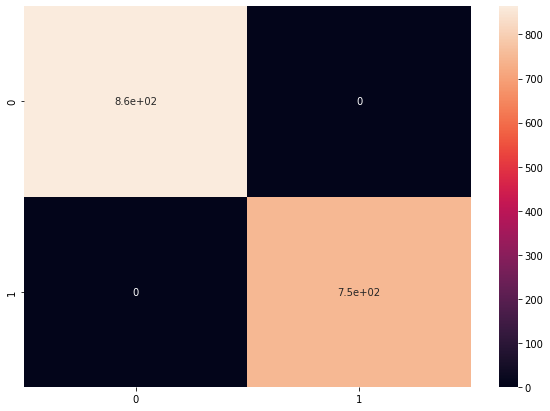

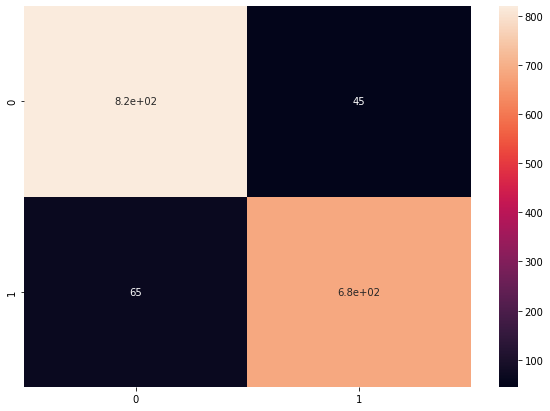

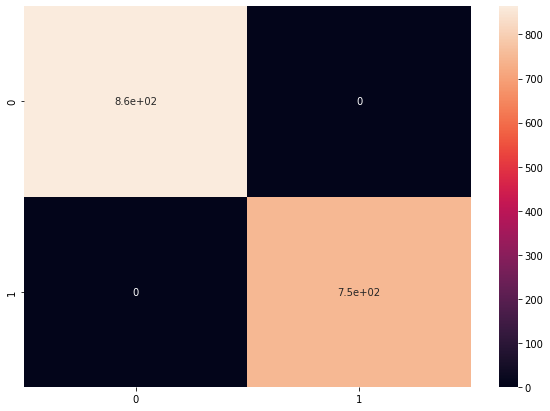

In [25]:
run_model(df_mushroom, 'class')

## income_evaluation.csv

21/12/10 22:38:00 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB



--Result of decision Tree---
result on test data
accuracy: 0.7923455272056563
precision: 0.7991743435771205
recall: 0.7923455272056563

--Result of naive bayes---
result on test data
accuracy: 0.7545342760528743
precision: 0.7648350103922028
recall: 0.7545342760528744


21/12/10 22:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1182.6 KiB
21/12/10 22:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1614.8 KiB
21/12/10 22:38:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
21/12/10 22:38:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/12/10 22:38:17 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
21/12/10 22:38:17 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
21/12/10 22:38:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
21/12/10 22:38:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
21/12/10 22:38:20 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
21/12/10 22:38:21 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
21/12/10 22:38:22 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
21/12/10 22:38:24 WARN DAGScheduler: Broadcastin


--Result of Random ForestClassifier--
result on test data
accuracy: 0.8379956962803566
precision: 0.8358433309534963
recall: 0.8379956962803565


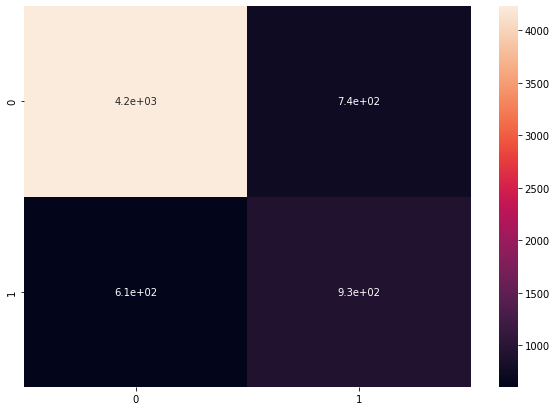

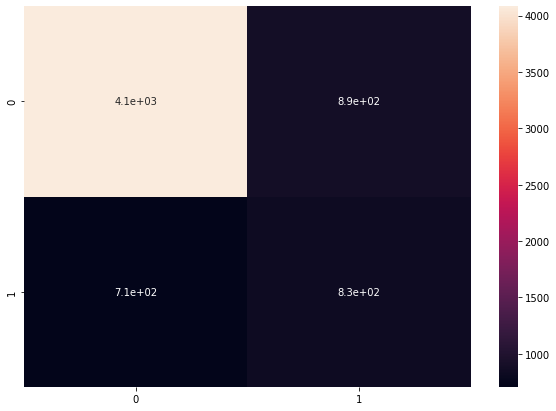

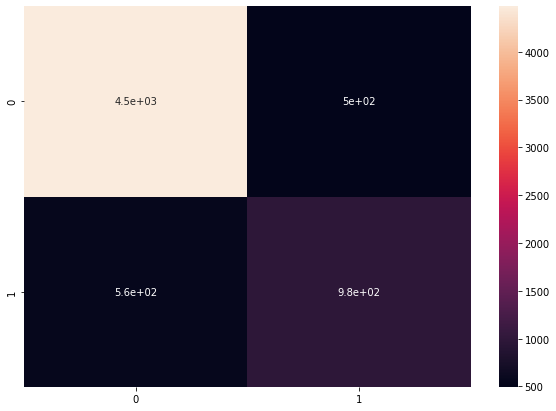

In [26]:
run_model(df_income, ' income')

## fetal_health.csv


--Result of decision Tree---
result on test data
accuracy: 0.8527315914489311
precision: 0.8544131939642361
recall: 0.8527315914489312

--Result of naive bayes---
result on test data
accuracy: 0.6935866983372921
precision: 0.8345560924728611
recall: 0.6935866983372923

--Result of Random ForestClassifier--
result on test data
accuracy: 0.8931116389548693
precision: 0.8908468518289354
recall: 0.8931116389548693


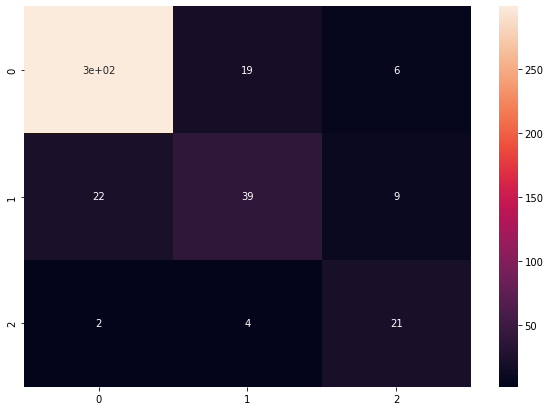

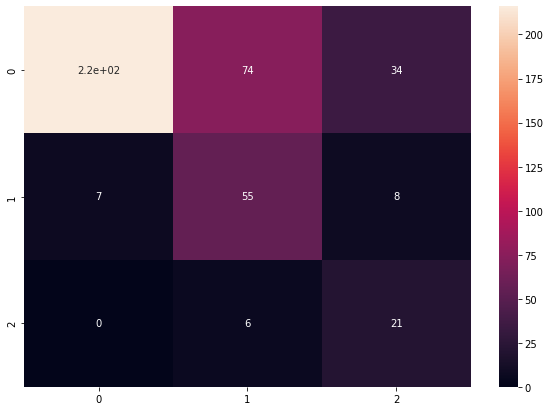

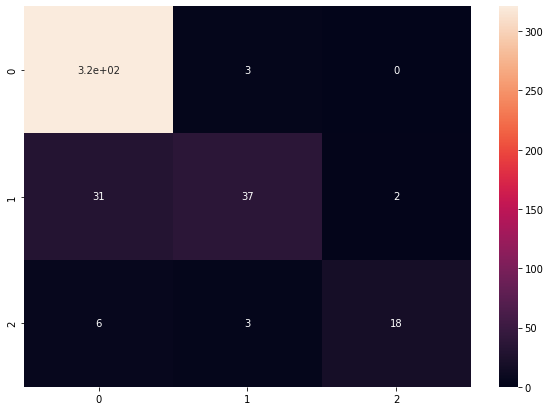

In [27]:
run_model(df_fetal, 'fetal_health')